# Phase 2: Vessel Segmentation and XY Registration

This notebook uses the OCTA-autosegmentation model to segment vessels from the MIP en-face projection.

## Workflow:
1. Load MIP from Phase 1
2. Prepare image for OCTA-autosegmentation (resize to 304×304)
3. Save as PNG and run pretrained model
4. Load vessel segmentation results
5. Extract vessel skeleton and bifurcation points
6. Save results for XY registration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import cv2
import subprocess
from skimage.morphology import skeletonize, binary_dilation
from scipy import ndimage

# Setup paths
data_dir = Path('data')
octa_seg_repo = Path('/home/aristarx/Diploma/OCTA-autosegmentation')

print("✓ Imports complete")

✓ Imports complete


## Step 1: Load MIP from Phase 1

Loaded MIP shape: (1536, 360)


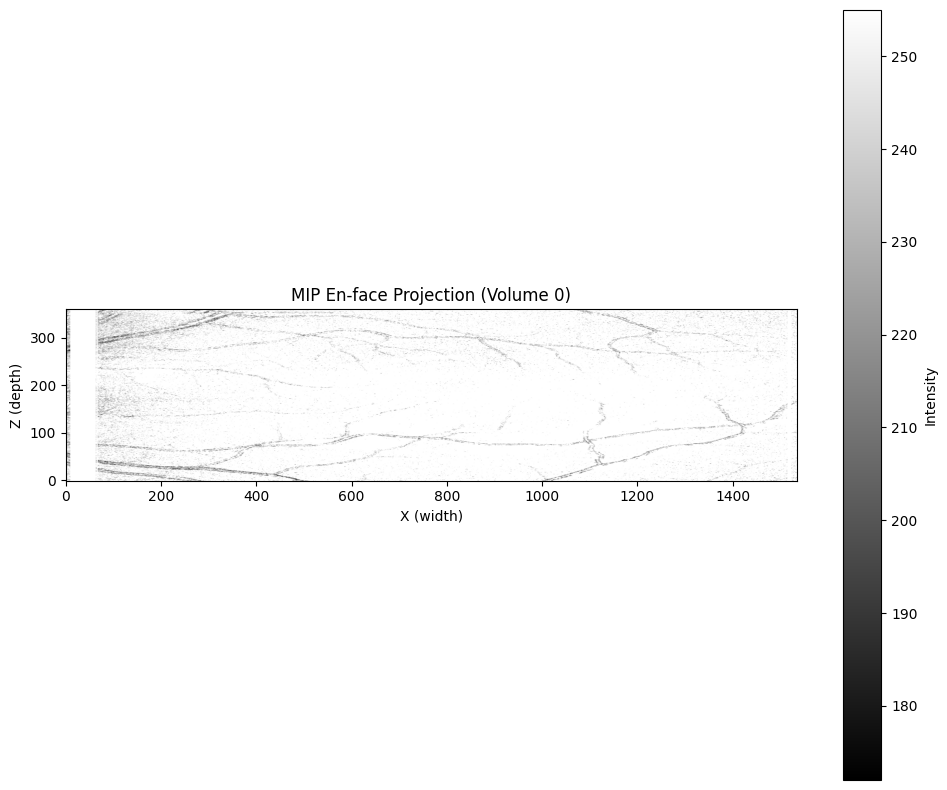

In [2]:
# Load saved MIP from Phase 1
enface_mip = np.load(data_dir / 'enface_mip_volume0.npy')
print(f"Loaded MIP shape: {enface_mip.shape}")

# Visualize
plt.figure(figsize=(10, 8))
plt.imshow(enface_mip.T, cmap='gray', origin='lower')
plt.title('MIP En-face Projection (Volume 0)')
plt.xlabel('X (width)')
plt.ylabel('Z (depth)')
plt.colorbar(label='Intensity')
plt.tight_layout()
plt.show()

## Step 2: Prepare Image for OCTA-autosegmentation

Prepared image shape: (304, 304)


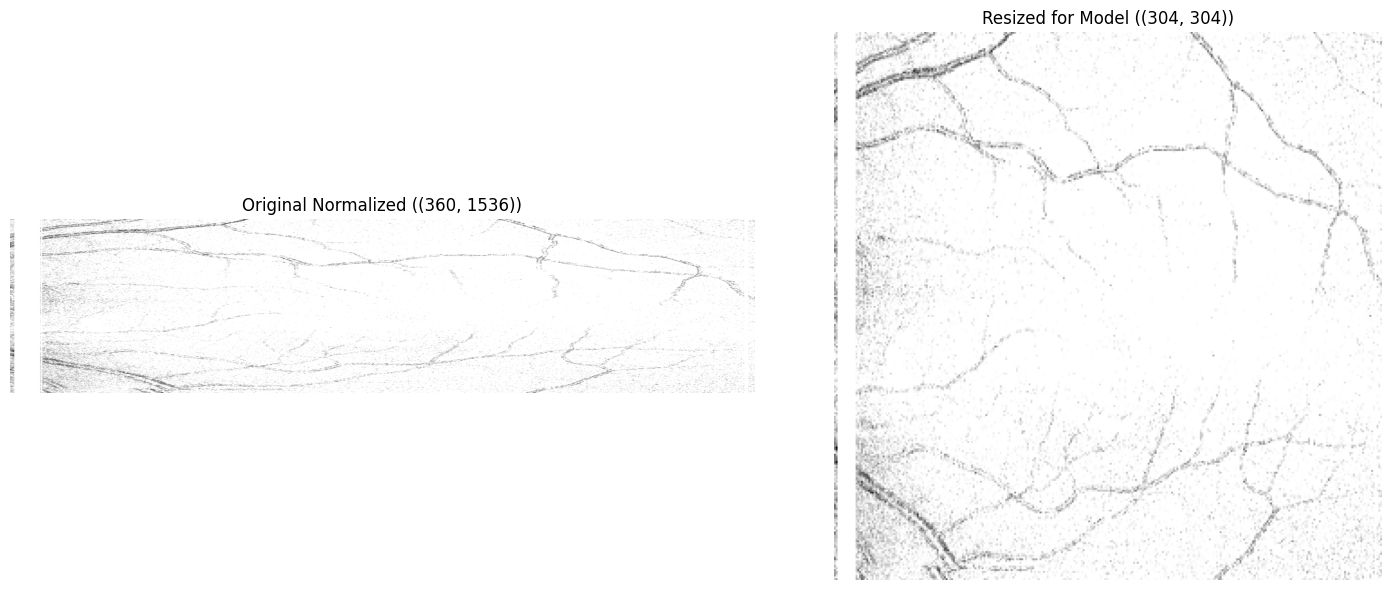

In [3]:
def prepare_image_for_octa_seg(enface_mip, target_size=(304, 304)):
    """
    Prepare MIP en-face image for OCTA-autosegmentation model.
    
    Args:
        enface_mip: MIP en-face projection (W, Z)
        target_size: Target size for model input
    
    Returns:
        img_prepared: Prepared image for model (H, W)
        img_original: Original normalized image
    """
    # Normalize to 0-255
    img_norm = ((enface_mip - enface_mip.min()) / 
                (enface_mip.max() - enface_mip.min()) * 255).astype(np.uint8)
    
    # Transpose to (Z, W) for standard image orientation
    img_norm = img_norm.T
    
    # Resize to model input size
    img_resized = cv2.resize(img_norm, target_size, interpolation=cv2.INTER_LINEAR)
    
    return img_resized, img_norm

# Prepare image
img_prepared, img_original = prepare_image_for_octa_seg(enface_mip)
print(f"Prepared image shape: {img_prepared.shape}")

# Visualize prepared image
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].imshow(img_original, cmap='gray')
axes[0].set_title(f'Original Normalized ({img_original.shape})')
axes[0].axis('off')

axes[1].imshow(img_prepared, cmap='gray')
axes[1].set_title(f'Resized for Model ({img_prepared.shape})')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Step 3: Save Image and Run OCTA-autosegmentation

In [4]:
# Create input/output directories
input_dir = data_dir / 'octa_seg_input'
output_dir = data_dir / 'octa_seg_output'
input_dir.mkdir(exist_ok=True, parents=True)
output_dir.mkdir(exist_ok=True, parents=True)

# Save prepared image
input_image_path = input_dir / 'volume0_mip.png'
cv2.imwrite(str(input_image_path), img_prepared)
print(f"✓ Saved input image to {input_image_path}")

# Prepare command for OCTA-autosegmentation
config_file = octa_seg_repo / 'docker/trained_models/ves_seg-S-GAN/config.yml'

# Use absolute paths since we run from octa_seg_repo directory
abs_input_dir = Path.cwd() / input_dir
abs_output_dir = Path.cwd() / output_dir

cmd = [
    sys.executable,
    str(octa_seg_repo / 'test.py'),
    '--config_file', str(config_file),
    '--Test.data.image.files', f'{abs_input_dir}/**/*.png',
    '--Test.save_dir', str(abs_output_dir),
    '--epoch', '30',
    '--General.device', 'cpu'
]

print(f"\nRunning OCTA-autosegmentation...")
print(f"Command: {' '.join(cmd)}")

# Run segmentation (must run from OCTA-autoseg directory for checkpoint paths)
result = subprocess.run(cmd, capture_output=True, text=True, cwd=str(octa_seg_repo))

if result.returncode == 0:
    print("\n✓ Segmentation complete!")
else:
    print(f"\n✗ Segmentation failed with return code {result.returncode}")
    print(f"STDOUT:\n{result.stdout}")
    print(f"STDERR:\n{result.stderr}")

✓ Saved input image to data/octa_seg_input/volume0_mip.png

Running OCTA-autosegmentation...
Command: /home/aristarx/Diploma/RetinaBuilder/venv/bin/python /home/aristarx/Diploma/OCTA-autosegmentation/test.py --config_file /home/aristarx/Diploma/OCTA-autosegmentation/docker/trained_models/ves_seg-S-GAN/config.yml --Test.data.image.files /home/aristarx/Diploma/RetinaBuilder/notebooks/data/octa_seg_input/**/*.png --Test.save_dir /home/aristarx/Diploma/RetinaBuilder/notebooks/data/octa_seg_output --epoch 30 --General.device cpu

✓ Segmentation complete!


## Step 4: Load and Visualize Segmentation Results

Found 1 segmentation result(s)
  - model_volume0_mip.png

Loading: data/octa_seg_output/model_volume0_mip.png
Vessel mask shape: (1216, 1216)
Vessel pixels: 530257 (35.86%)


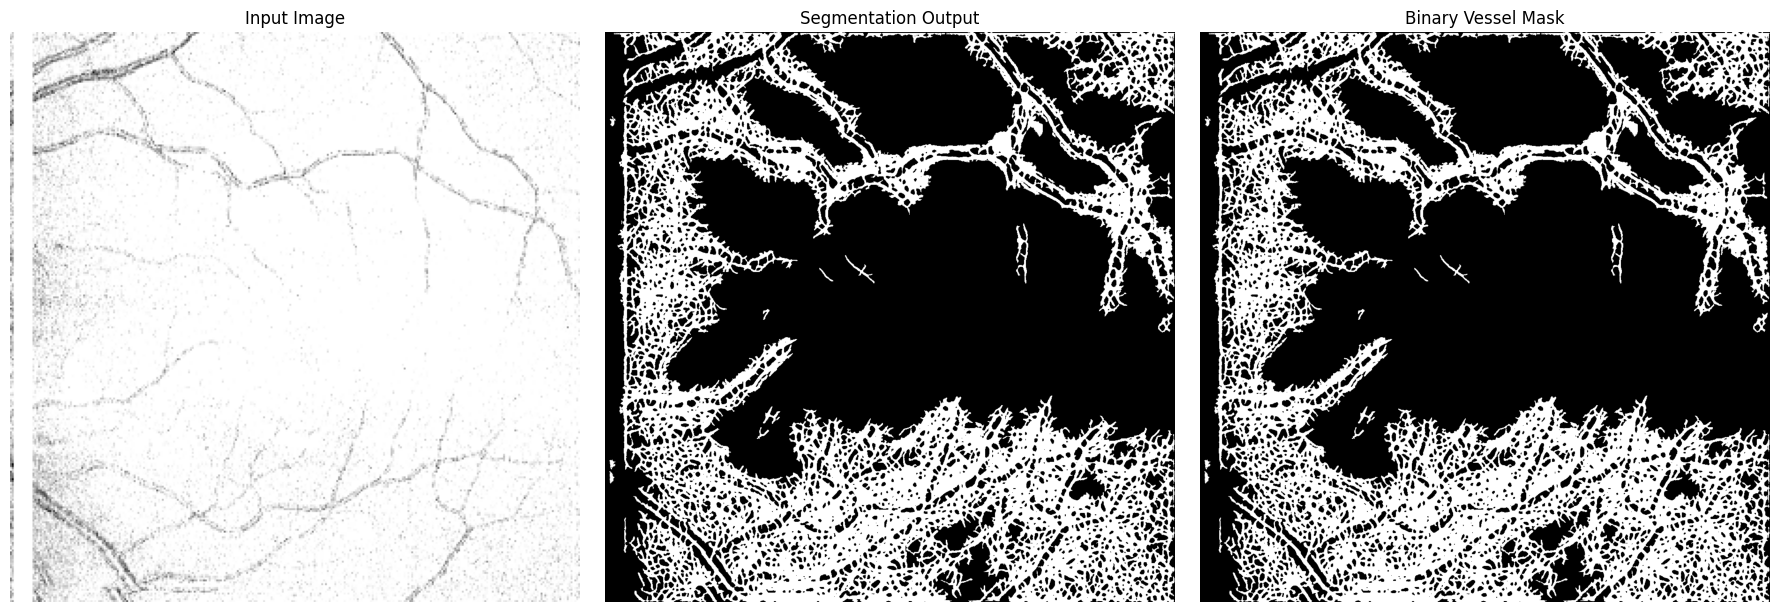

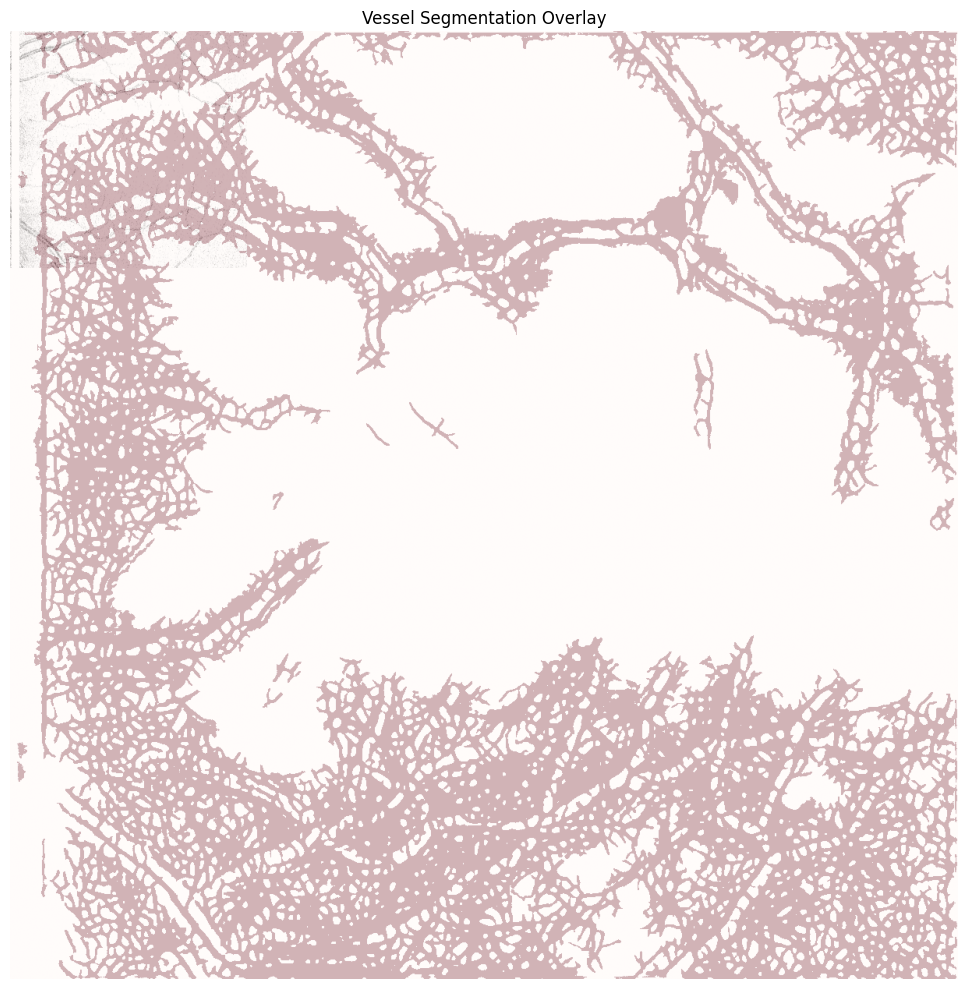

In [5]:
# Find segmentation output (OCTA-autoseg outputs as "model_*.png" not "*pred*.png")
seg_files = list(output_dir.glob('**/*.png'))
print(f"Found {len(seg_files)} segmentation result(s)")
if seg_files:
    for f in seg_files:
        print(f"  - {f.name}")

if seg_files:
    seg_path = seg_files[0]
    print(f"\nLoading: {seg_path}")
    
    # Load segmentation
    vessel_seg = cv2.imread(str(seg_path), cv2.IMREAD_GRAYSCALE)
    
    # Convert to binary mask (threshold at 127)
    vessel_mask = vessel_seg > 127
    
    print(f"Vessel mask shape: {vessel_mask.shape}")
    print(f"Vessel pixels: {vessel_mask.sum()} ({100*vessel_mask.sum()/vessel_mask.size:.2f}%)")
    
    # Visualize results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(img_prepared, cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')
    
    axes[1].imshow(vessel_seg, cmap='gray')
    axes[1].set_title('Segmentation Output')
    axes[1].axis('off')
    
    axes[2].imshow(vessel_mask, cmap='gray')
    axes[2].set_title('Binary Vessel Mask')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Overlay visualization
    plt.figure(figsize=(10, 10))
    plt.imshow(img_prepared, cmap='gray', alpha=0.7)
    plt.imshow(vessel_mask, cmap='Reds', alpha=0.3)
    plt.title('Vessel Segmentation Overlay')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("⚠ No segmentation results found!")

## Step 5: Extract Vessel Skeleton and Bifurcations

Step 1: Extract all bifurcation candidates...
  Skeleton pixels: 84701
  Raw bifurcations (3+ neighbors): 18050

Step 2: Cluster nearby points to remove pixelation artifacts...
  After clustering: 3632
  Removed: 14418 artifacts

Step 3: Filter by image quality...
  After quality filter: 2094
  Removed: 1538 low-quality points


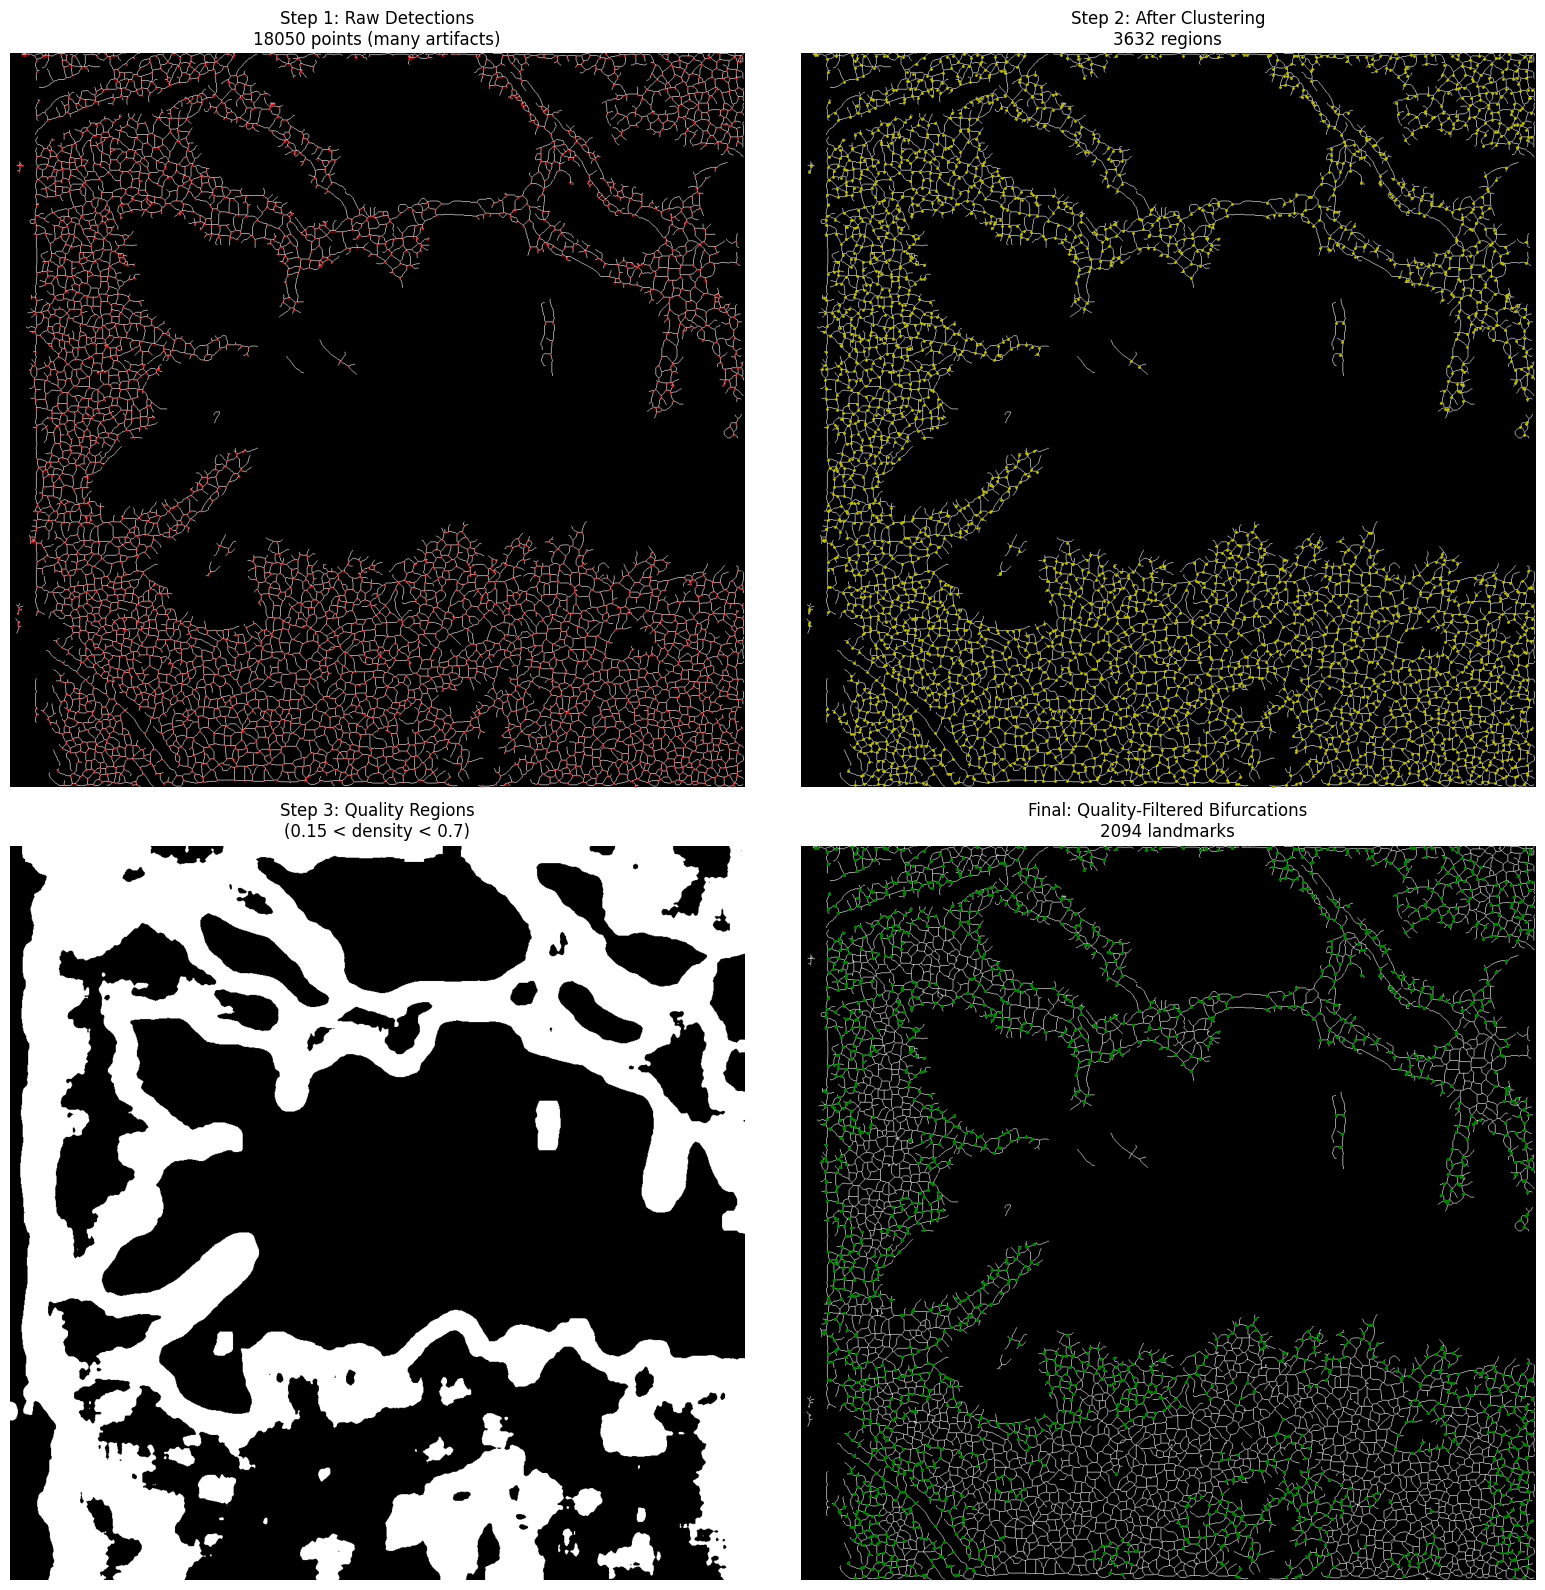

/tmp/ipykernel_170691/1584545870.py:158: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axes[i].imshow(patch, cmap='gray')


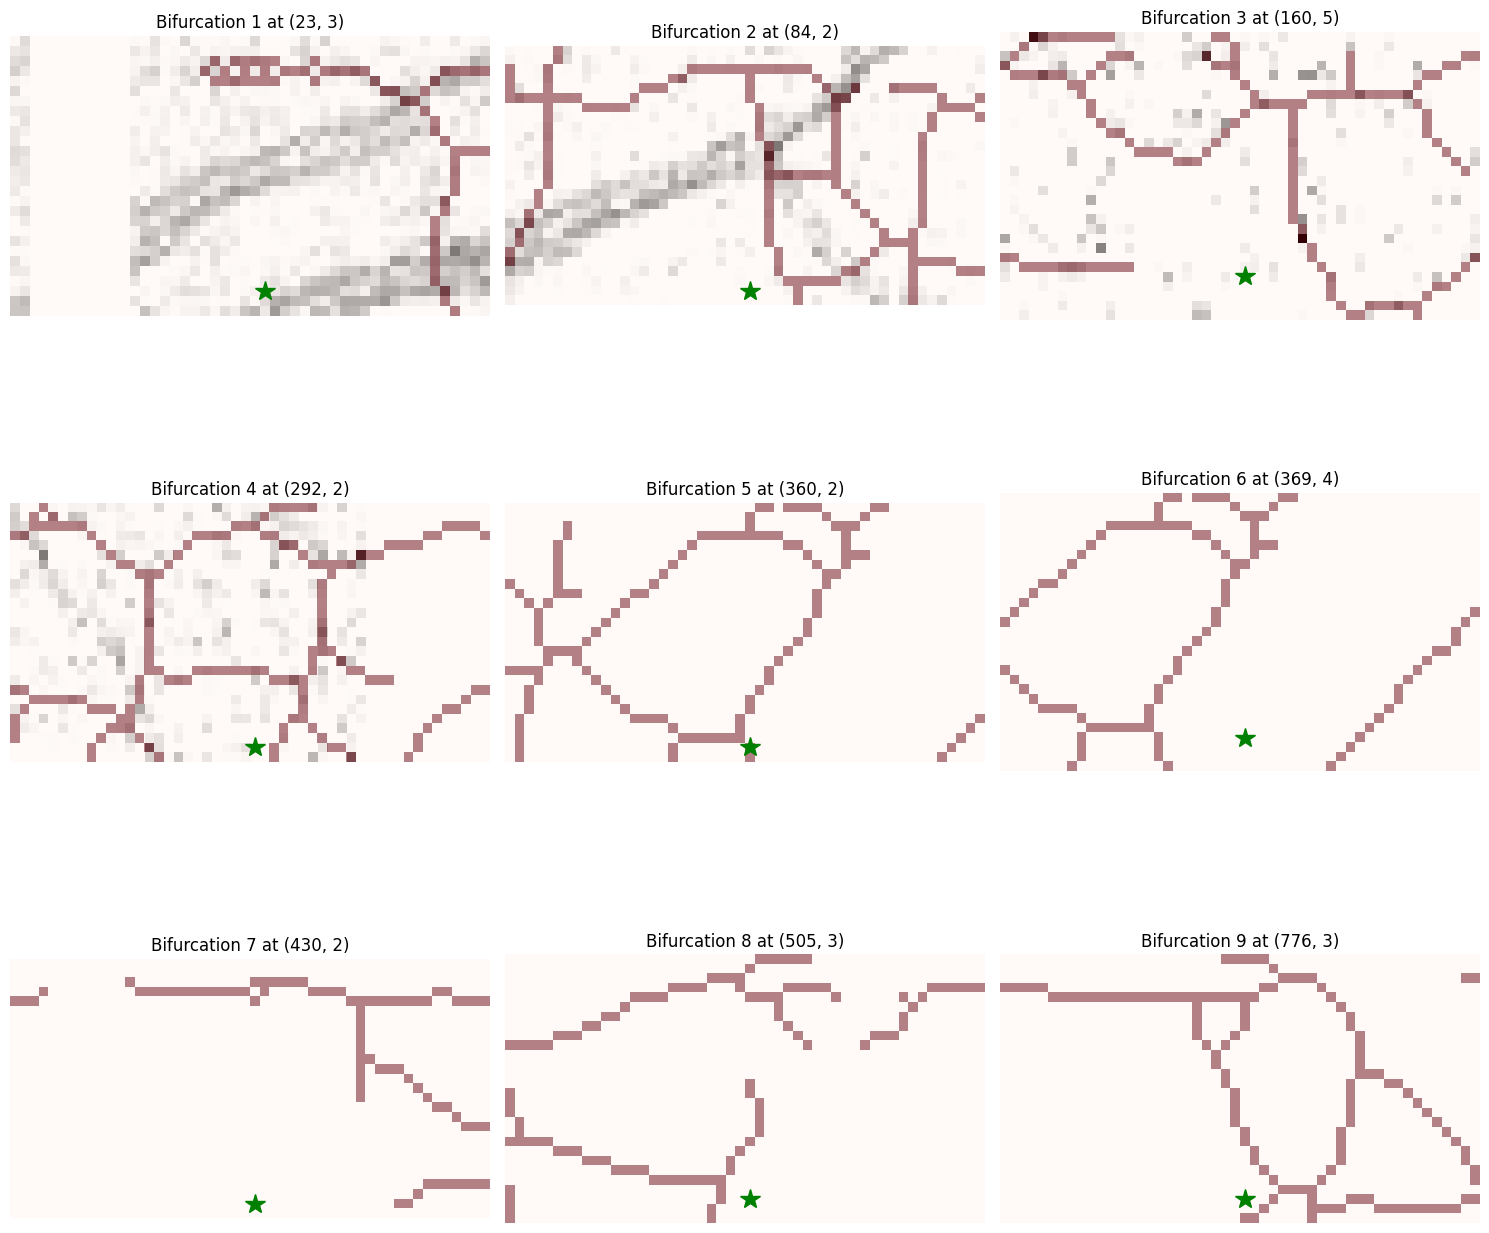

In [6]:
def extract_bifurcations(skeleton):
    """
    Extract bifurcation points from vessel skeleton.
    Bifurcations are points where 3 or more vessel centerlines meet.
    
    Args:
        skeleton: Binary skeleton image
    
    Returns:
        bifurcations: Binary image with bifurcation points
        coords: (N, 2) array of bifurcation coordinates (y, x)
    """
    # Count neighbors for each skeleton pixel
    kernel = np.ones((3, 3), dtype=np.uint8)
    kernel[1, 1] = 0  # Don't count center pixel
    
    # Convolve to count neighbors
    neighbor_count = ndimage.convolve(skeleton.astype(np.uint8), kernel, mode='constant')
    
    # Bifurcations have 3+ neighbors (includes real bifurcations + pixelation artifacts)
    bifurcations = (neighbor_count >= 3) & skeleton
    
    # Get coordinates
    coords = np.column_stack(np.where(bifurcations))
    
    return bifurcations, coords

def cluster_bifurcations(coords, min_distance=8):
    """
    Cluster nearby bifurcation points to remove pixelation artifacts.
    Each cluster represents one true bifurcation region.
    
    Args:
        coords: (N, 2) array of bifurcation coordinates
        min_distance: Minimum distance between distinct bifurcations (pixels)
    
    Returns:
        clustered_coords: (M, 2) array of cluster centroids
    """
    if len(coords) == 0:
        return coords
    
    # Use non-maximum suppression in local neighborhoods
    filtered = []
    used = np.zeros(len(coords), dtype=bool)
    
    for i in range(len(coords)):
        if used[i]:
            continue
        y, x = coords[i]
        
        # Find nearby candidates
        distances = np.sqrt((coords[:, 0] - y)**2 + (coords[:, 1] - x)**2)
        nearby = distances < min_distance
        
        # Mark all nearby as used
        used[nearby] = True
        
        # Keep the centroid of the cluster
        cluster = coords[nearby]
        centroid = cluster.mean(axis=0).astype(int)
        filtered.append(centroid)
    
    return np.array(filtered)

def filter_by_quality(coords, vessel_mask, density_range=(0.15, 0.7), window_size=50):
    """
    Filter bifurcations by image quality.
    Removes points in noisy/sparse regions and overly dense regions.
    
    Args:
        coords: (N, 2) array of bifurcation coordinates
        vessel_mask: Binary vessel segmentation mask
        density_range: (min, max) acceptable vessel density
        window_size: Size of local density measurement window
    
    Returns:
        filtered_coords: Quality-filtered bifurcation coordinates
    """
    # Compute local vessel density
    vessel_density = ndimage.uniform_filter(vessel_mask.astype(float), size=window_size)
    
    # Quality mask: moderate vessel density
    quality_mask = (vessel_density > density_range[0]) & (vessel_density < density_range[1])
    
    # Filter bifurcations
    filtered = []
    for y, x in coords:
        if quality_mask[y, x]:
            filtered.append([y, x])
    
    return np.array(filtered) if filtered else np.array([]).reshape(0, 2)

if seg_files:
    print("Step 1: Extract all bifurcation candidates...")
    # Extract skeleton
    vessel_skeleton = skeletonize(vessel_mask)
    print(f"  Skeleton pixels: {vessel_skeleton.sum()}")
    
    # Extract raw bifurcations (3+ neighbors)
    bifurcations_raw, bifurcation_coords_raw = extract_bifurcations(vessel_skeleton)
    print(f"  Raw bifurcations (3+ neighbors): {len(bifurcation_coords_raw)}")
    
    print("\nStep 2: Cluster nearby points to remove pixelation artifacts...")
    bifurcation_coords_clustered = cluster_bifurcations(bifurcation_coords_raw, min_distance=8)
    print(f"  After clustering: {len(bifurcation_coords_clustered)}")
    print(f"  Removed: {len(bifurcation_coords_raw) - len(bifurcation_coords_clustered)} artifacts")
    
    print("\nStep 3: Filter by image quality...")
    bifurcation_coords = filter_by_quality(bifurcation_coords_clustered, vessel_mask)
    print(f"  After quality filter: {len(bifurcation_coords)}")
    print(f"  Removed: {len(bifurcation_coords_clustered) - len(bifurcation_coords)} low-quality points")
    
    # Visualize filtering steps
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    
    axes[0, 0].imshow(vessel_skeleton, cmap='gray')
    axes[0, 0].plot(bifurcation_coords_raw[:, 1], bifurcation_coords_raw[:, 0], 'r.', markersize=1, alpha=0.2)
    axes[0, 0].set_title(f'Step 1: Raw Detections\n{len(bifurcation_coords_raw)} points (many artifacts)')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(vessel_skeleton, cmap='gray')
    axes[0, 1].plot(bifurcation_coords_clustered[:, 1], bifurcation_coords_clustered[:, 0], 'y.', markersize=2)
    axes[0, 1].set_title(f'Step 2: After Clustering\n{len(bifurcation_coords_clustered)} regions')
    axes[0, 1].axis('off')
    
    # Show quality mask
    vessel_density = ndimage.uniform_filter(vessel_mask.astype(float), size=50)
    quality_mask = (vessel_density > 0.15) & (vessel_density < 0.7)
    axes[1, 0].imshow(quality_mask, cmap='gray')
    axes[1, 0].set_title('Step 3: Quality Regions\n(0.15 < density < 0.7)')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(vessel_skeleton, cmap='gray')
    axes[1, 1].plot(bifurcation_coords[:, 1], bifurcation_coords[:, 0], 'g.', markersize=3)
    axes[1, 1].set_title(f'Final: Quality-Filtered Bifurcations\n{len(bifurcation_coords)} landmarks')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Detailed view of final bifurcations
    if len(bifurcation_coords) > 0:
        # Show first 9 bifurcations in detail
        n_show = min(9, len(bifurcation_coords))
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))
        axes = axes.flatten()
        
        window = 25  # pixels around bifurcation
        for i in range(n_show):
            y, x = bifurcation_coords[i]
            y_min, y_max = max(0, y-window), min(vessel_skeleton.shape[0], y+window)
            x_min, x_max = max(0, x-window), min(vessel_skeleton.shape[1], x+window)
            
            patch = img_prepared[y_min:y_max, x_min:x_max]
            skel_patch = vessel_skeleton[y_min:y_max, x_min:x_max]
            
            axes[i].imshow(patch, cmap='gray')
            axes[i].imshow(skel_patch, cmap='Reds', alpha=0.5)
            axes[i].plot(window, window, 'g*', markersize=15)
            axes[i].set_title(f'Bifurcation {i+1} at ({x}, {y})')
            axes[i].axis('off')
        
        for i in range(n_show, 9):
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()

## Step 6: Save Results for Registration

In [7]:
if seg_files and len(bifurcation_coords) > 0:
    # Save all results
    np.save(data_dir / 'vessel_mask_volume0.npy', vessel_mask)
    np.save(data_dir / 'vessel_skeleton_volume0.npy', vessel_skeleton)
    np.save(data_dir / 'bifurcation_coords_volume0.npy', bifurcation_coords)
    
    print("✓ Saved results:")
    print(f"  - vessel_mask_volume0.npy: {vessel_mask.shape}")
    print(f"  - vessel_skeleton_volume0.npy: {vessel_skeleton.shape}")
    print(f"  - bifurcation_coords_volume0.npy: {bifurcation_coords.shape}")
    
    print("\n📊 Summary:")
    print(f"  Original MIP shape: {enface_mip.shape}")
    print(f"  Segmentation shape: {vessel_mask.shape}")
    print(f"  Vessel coverage: {100*vessel_mask.sum()/vessel_mask.size:.2f}%")
    print(f"  Skeleton length: {vessel_skeleton.sum()} pixels")
    print(f"  Final bifurcation landmarks: {len(bifurcation_coords)}")
    print(f"\n  Quality metrics:")
    print(f"    - Raw detections: {len(bifurcation_coords_raw)}")
    print(f"    - After clustering: {len(bifurcation_coords_clustered)}")
    print(f"    - After quality filter: {len(bifurcation_coords)}")
    print(f"    - Artifact removal: {100*(1-len(bifurcation_coords)/len(bifurcation_coords_raw)):.1f}%")
    
    print("\n✓ Phase 2 vessel segmentation complete!")
    print("\nNext steps:")
    print("  1. Process volume 1 with same pipeline")
    print("  2. Match bifurcation patterns between volumes")
    print("  3. Calculate XY offset for alignment")
    print("  4. Apply registration transform")
else:
    print("⚠ Cannot save results - segmentation failed or no bifurcations found")

✓ Saved results:
  - vessel_mask_volume0.npy: (1216, 1216)
  - vessel_skeleton_volume0.npy: (1216, 1216)
  - bifurcation_coords_volume0.npy: (2094, 2)

📊 Summary:
  Original MIP shape: (1536, 360)
  Segmentation shape: (1216, 1216)
  Vessel coverage: 35.86%
  Skeleton length: 84701 pixels
  Final bifurcation landmarks: 2094

  Quality metrics:
    - Raw detections: 18050
    - After clustering: 3632
    - After quality filter: 2094
    - Artifact removal: 88.4%

✓ Phase 2 vessel segmentation complete!

Next steps:
  1. Process volume 1 with same pipeline
  2. Match bifurcation patterns between volumes
  3. Calculate XY offset for alignment
  4. Apply registration transform


In [8]:
# Define directories (in case previous cell wasn't run)
input_dir_v1 = data_dir / 'octa_seg_input_v1'
output_dir_v1 = data_dir / 'octa_seg_output_v1'

# Load and process volume 1 segmentation results
seg_files_v1 = list(output_dir_v1.glob('**/*.png'))
print(f"Found {len(seg_files_v1)} segmentation result(s) for volume 1")

if seg_files_v1:
    # Load segmentation
    vessel_seg_v1 = cv2.imread(str(seg_files_v1[0]), cv2.IMREAD_GRAYSCALE)
    vessel_mask_v1 = vessel_seg_v1 > 127
    
    print(f"Vessel mask shape: {vessel_mask_v1.shape}")
    print(f"Vessel coverage: {100*vessel_mask_v1.sum()/vessel_mask_v1.size:.2f}%")
    
    # Extract and filter bifurcations
    print("\nStep 1: Extract bifurcation candidates...")
    vessel_skeleton_v1 = skeletonize(vessel_mask_v1)
    bifurcations_raw_v1, bifurcation_coords_raw_v1 = extract_bifurcations(vessel_skeleton_v1)
    print(f"  Raw bifurcations: {len(bifurcation_coords_raw_v1)}")
    
    print("\nStep 2: Cluster nearby points...")
    bifurcation_coords_clustered_v1 = cluster_bifurcations(bifurcation_coords_raw_v1, min_distance=8)
    print(f"  After clustering: {len(bifurcation_coords_clustered_v1)}")
    
    print("\nStep 3: Filter by quality...")
    bifurcation_coords_v1 = filter_by_quality(bifurcation_coords_clustered_v1, vessel_mask_v1)
    print(f"  Final bifurcations: {len(bifurcation_coords_v1)}")
    
    # Save results
    np.save(data_dir / 'vessel_mask_volume1.npy', vessel_mask_v1)
    np.save(data_dir / 'vessel_skeleton_volume1.npy', vessel_skeleton_v1)
    np.save(data_dir / 'bifurcation_coords_volume1.npy', bifurcation_coords_v1)
    
    print(f"\n✓ Saved volume 1 results")
    print(f"\n📊 Comparison:")
    print(f"  Volume 0: {len(bifurcation_coords)} bifurcations")
    print(f"  Volume 1: {len(bifurcation_coords_v1)} bifurcations")
    print(f"\n✓ Ready for Phase 3: XY registration!")
else:
    print("⚠ No segmentation results found for volume 1")

Found 1 segmentation result(s) for volume 1
Vessel mask shape: (1216, 1216)
Vessel coverage: 52.16%

Step 1: Extract bifurcation candidates...
  Raw bifurcations: 31388

Step 2: Cluster nearby points...
  After clustering: 6240

Step 3: Filter by quality...
  Final bifurcations: 5539

✓ Saved volume 1 results

📊 Comparison:
  Volume 0: 2094 bifurcations
  Volume 1: 5539 bifurcations

✓ Ready for Phase 3: XY registration!


In [9]:
# Load and process volume 1 segmentation results
seg_files_v1 = list(output_dir_v1.glob('**/*.png'))
print(f"Found {len(seg_files_v1)} segmentation result(s) for volume 1")

if seg_files_v1:
    # Load segmentation
    vessel_seg_v1 = cv2.imread(str(seg_files_v1[0]), cv2.IMREAD_GRAYSCALE)
    vessel_mask_v1 = vessel_seg_v1 > 127
    
    print(f"Vessel mask shape: {vessel_mask_v1.shape}")
    print(f"Vessel coverage: {100*vessel_mask_v1.sum()/vessel_mask_v1.size:.2f}%")
    
    # Extract and filter bifurcations
    print("\nStep 1: Extract bifurcation candidates...")
    vessel_skeleton_v1 = skeletonize(vessel_mask_v1)
    bifurcations_raw_v1, bifurcation_coords_raw_v1 = extract_bifurcations(vessel_skeleton_v1)
    print(f"  Raw bifurcations: {len(bifurcation_coords_raw_v1)}")
    
    print("\nStep 2: Cluster nearby points...")
    bifurcation_coords_clustered_v1 = cluster_bifurcations(bifurcation_coords_raw_v1, min_distance=8)
    print(f"  After clustering: {len(bifurcation_coords_clustered_v1)}")
    
    print("\nStep 3: Filter by quality...")
    bifurcation_coords_v1 = filter_by_quality(bifurcation_coords_clustered_v1, vessel_mask_v1)
    print(f"  Final bifurcations: {len(bifurcation_coords_v1)}")
    
    # Save results
    np.save(data_dir / 'vessel_mask_volume1.npy', vessel_mask_v1)
    np.save(data_dir / 'vessel_skeleton_volume1.npy', vessel_skeleton_v1)
    np.save(data_dir / 'bifurcation_coords_volume1.npy', bifurcation_coords_v1)
    
    print(f"\n✓ Saved volume 1 results")
    print(f"\n📊 Comparison:")
    print(f"  Volume 0: {len(bifurcation_coords)} bifurcations")
    print(f"  Volume 1: {len(bifurcation_coords_v1)} bifurcations")
    print(f"\n✓ Ready for Phase 3: XY registration!")
else:
    print("⚠ No segmentation results found for volume 1")

Found 1 segmentation result(s) for volume 1
Vessel mask shape: (1216, 1216)
Vessel coverage: 52.16%

Step 1: Extract bifurcation candidates...
  Raw bifurcations: 31388

Step 2: Cluster nearby points...
  After clustering: 6240

Step 3: Filter by quality...
  Final bifurcations: 5539

✓ Saved volume 1 results

📊 Comparison:
  Volume 0: 2094 bifurcations
  Volume 1: 5539 bifurcations

✓ Ready for Phase 3: XY registration!


In [10]:
# Load MIP from Phase 1
enface_mip_v1 = np.load(data_dir / 'enface_mip_volume1.npy')
print(f"Loaded volume 1 MIP shape: {enface_mip_v1.shape}")

# Prepare image for OCTA-autosegmentation
img_prepared_v1, img_original_v1 = prepare_image_for_octa_seg(enface_mip_v1)
print(f"Prepared image shape: {img_prepared_v1.shape}")

# Create input/output directories for volume 1
input_dir_v1 = data_dir / 'octa_seg_input_v1'
output_dir_v1 = data_dir / 'octa_seg_output_v1'
input_dir_v1.mkdir(exist_ok=True, parents=True)
output_dir_v1.mkdir(exist_ok=True, parents=True)

# Save prepared image
input_image_path_v1 = input_dir_v1 / 'volume1_mip.png'
cv2.imwrite(str(input_image_path_v1), img_prepared_v1)
print(f"✓ Saved input image to {input_image_path_v1}")

# Prepare command for OCTA-autosegmentation
abs_input_dir_v1 = Path.cwd() / input_dir_v1
abs_output_dir_v1 = Path.cwd() / output_dir_v1

cmd_v1 = [
    sys.executable,
    str(octa_seg_repo / 'test.py'),
    '--config_file', str(config_file),
    '--Test.data.image.files', f'{abs_input_dir_v1}/**/*.png',
    '--Test.save_dir', str(abs_output_dir_v1),
    '--epoch', '30',
    '--General.device', 'cpu'
]

print(f"\nRunning OCTA-autosegmentation on volume 1...")
result_v1 = subprocess.run(cmd_v1, capture_output=True, text=True, cwd=str(octa_seg_repo))

if result_v1.returncode == 0:
    print("✓ Segmentation complete!")
else:
    print(f"✗ Segmentation failed with return code {result_v1.returncode}")
    print(f"STDERR:\n{result_v1.stderr}")

Loaded volume 1 MIP shape: (1536, 360)
Prepared image shape: (304, 304)
✓ Saved input image to data/octa_seg_input_v1/volume1_mip.png

Running OCTA-autosegmentation on volume 1...
✓ Segmentation complete!


---
## Process Volume 1

Apply the same vessel segmentation pipeline to volume 1.